# Plot Histogram for Normal and Sick X ray images

## Import and set paths

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure
import seaborn as sns


In [3]:
data_address = os.path.join(os.getcwd(),'..', 'Data')
image_address = os.path.join(data_address, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset')
training_label = pd.read_csv(os.path.join(data_address, 'training_label.csv'))
testing_label = pd.read_csv(os.path.join(data_address, 'testing_label.csv'))


In [4]:
train_images_normal = [os.path.join(image_address, 'train', filename) for filename in training_label[training_label.Label == 'Normal'].X_ray_image_name.tolist()]
train_images_sick = [os.path.join(image_address, 'train', filename) for filename in training_label[training_label.Label == 'Pnemonia'].X_ray_image_name.tolist()]
test_images_normal = [os.path.join(image_address, 'test', filename) for filename in testing_label[testing_label.Label == 'Normal'].X_ray_image_name.tolist()]
test_images_sick = [os.path.join(image_address, 'test', filename) for filename in testing_label[testing_label.Label == 'Pnemonia'].X_ray_image_name.tolist()]


## Normal vs Sick

#### Preview the images for both normal and phemonia types

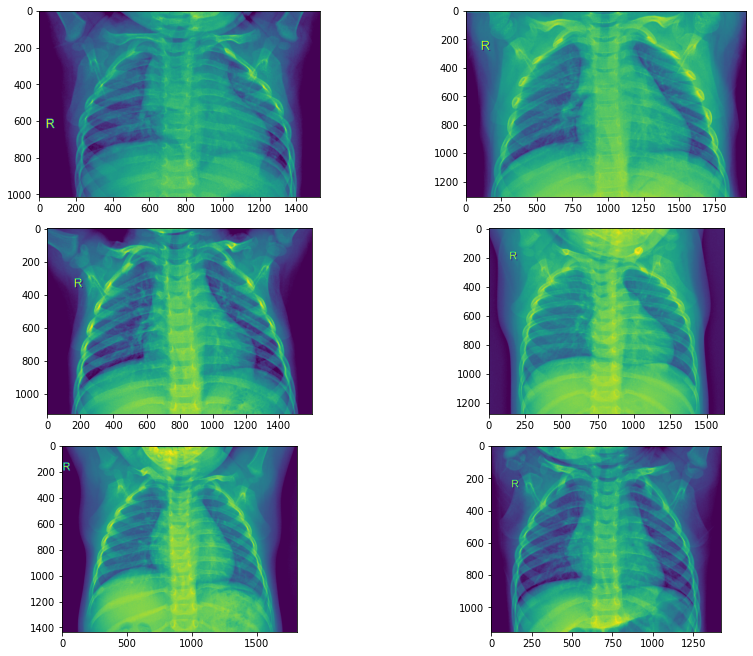

In [14]:
from PIL import Image
path_draw = train_images_normal[:6]
plt.figure(figsize = (12,12))
for i, v in enumerate(path_draw):
    try:
        image = Image.open(v)
        plt.subplot(4,2,i+1)
        plt.imshow(image)
    except:
        continue

plt.tight_layout()

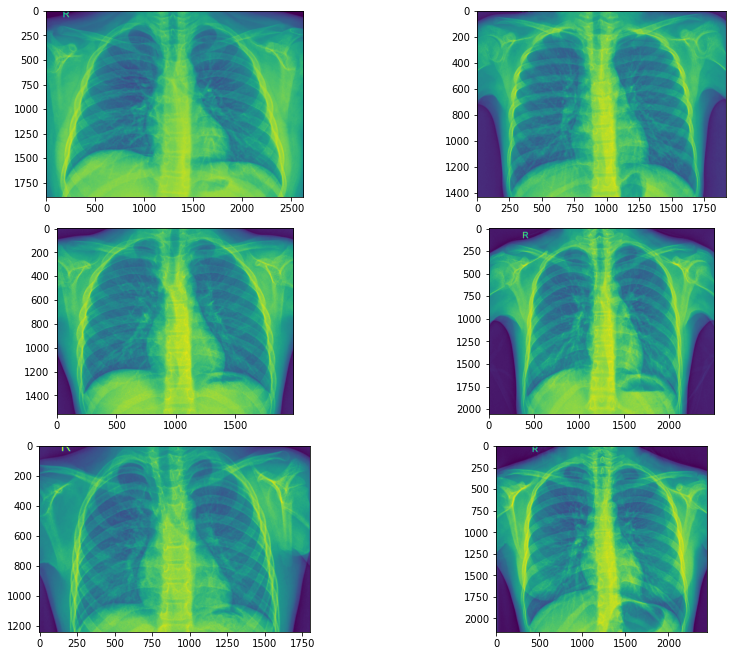

In [6]:
from PIL import Image
path_draw = test_images_normal[:6]

plt.figure(figsize = (12,12))
for i, v in enumerate(path_draw):
    try:
        image = Image.open(v)
        plt.subplot(4,2,i+1)
        plt.imshow(image)
    except:
        continue

plt.tight_layout()

#### Plot histograms of pixel intensities

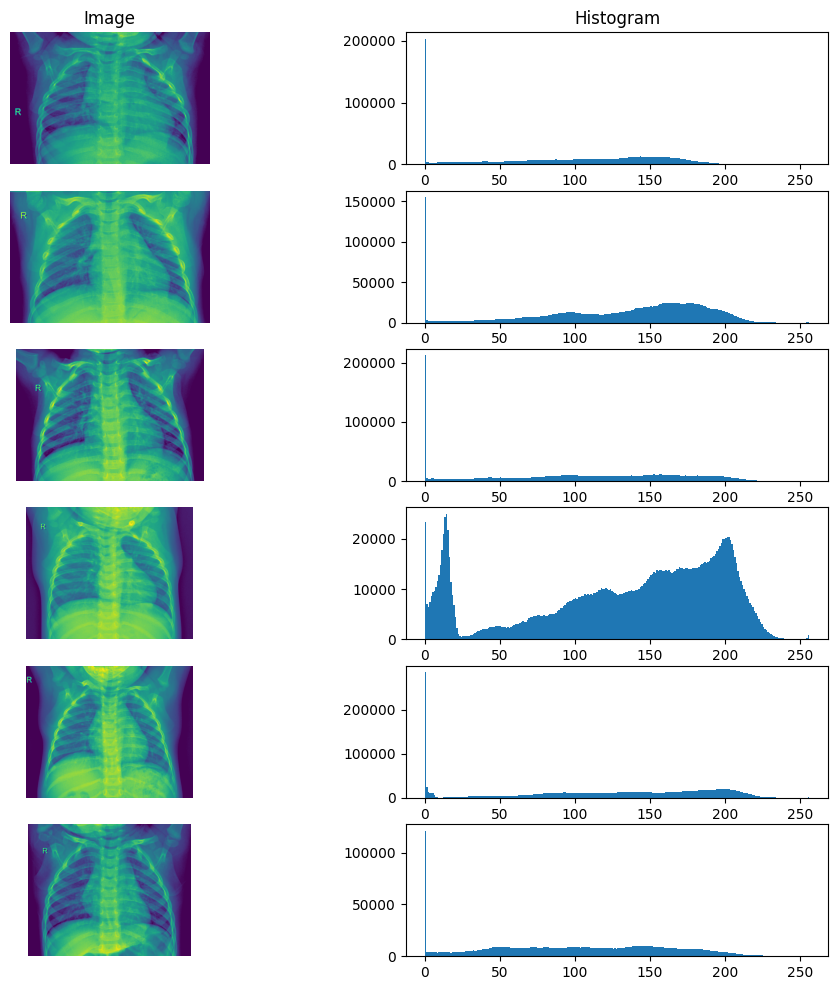

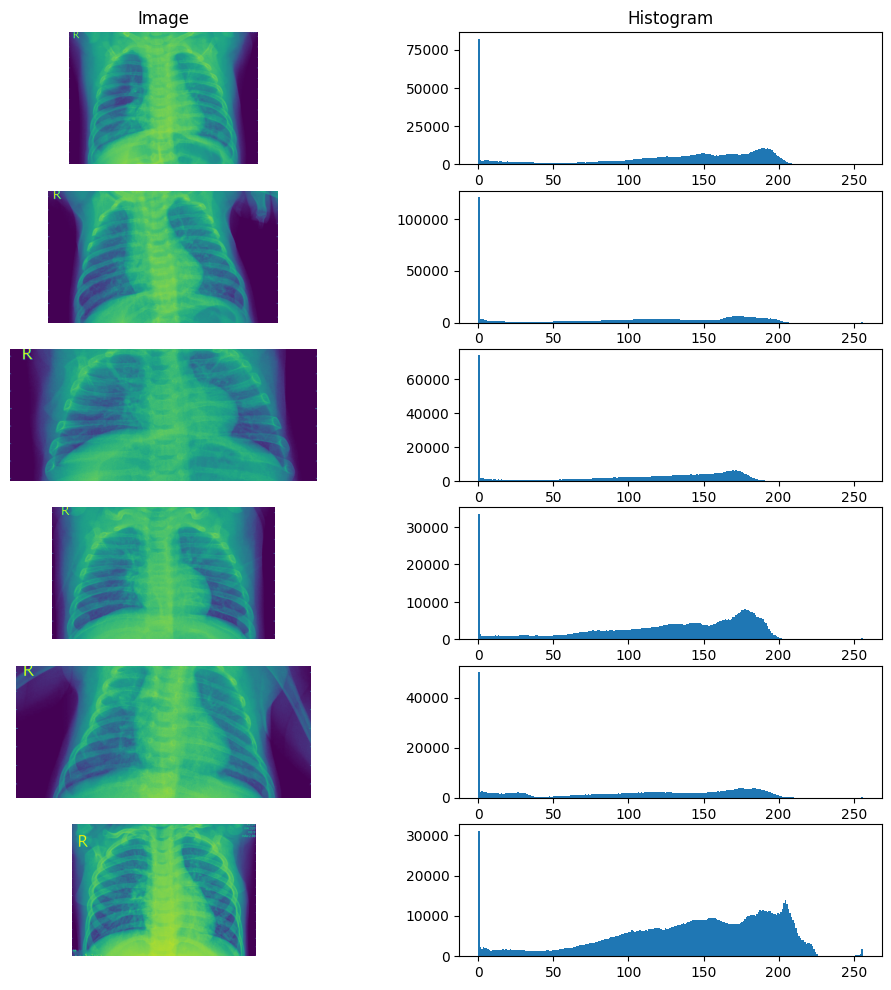

In [6]:
# Histogram analysis
def plot_graph_hist(path_draw, figsize = (12,12), title_left = 'Image', title_right = 'Histogram', mode = None):
    fig, ax = plt.subplots(len(path_draw), 2, figsize=figsize)
    for i, v in enumerate(path_draw):
        image = plt.imread(v)
        ax[i, 0].imshow(image)
        if mode == 'RGB':
            for col, channel in zip('rgb', np.rollaxis(image, axis=-1)):
                hist, bin_centers = exposure.histogram(channel)
                ax[i, 1].fill_between(bin_centers, hist, color=col, alpha=0.4)
        else:
            ax[i, 1].hist(image.ravel(), 256, [0, 256])
            ax[i, 0].axis('off')
        if i == 0:
            ax[i, 0].set_title(title_left)
            ax[i, 1].set_title(title_right)
    plt.show()
for paths in [train_images_normal[:6], test_images_sick[:6]]:
    plot_graph_hist(paths)

Q: Why train normal and test sick here?

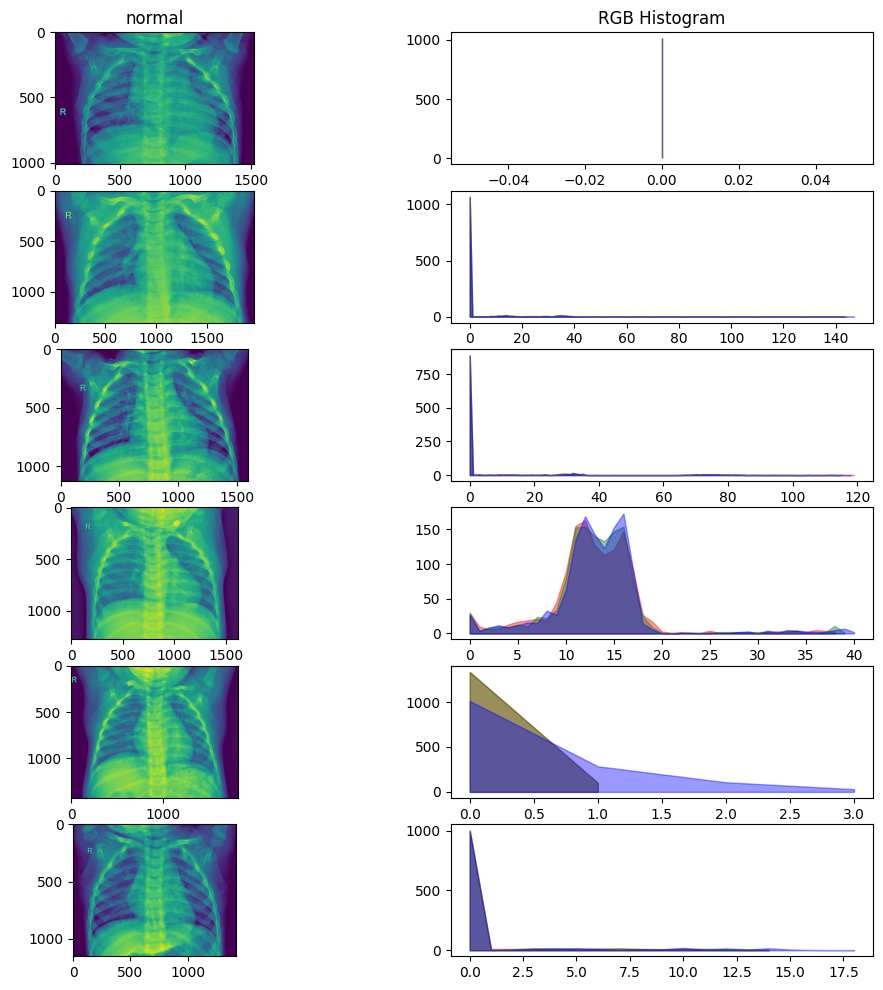

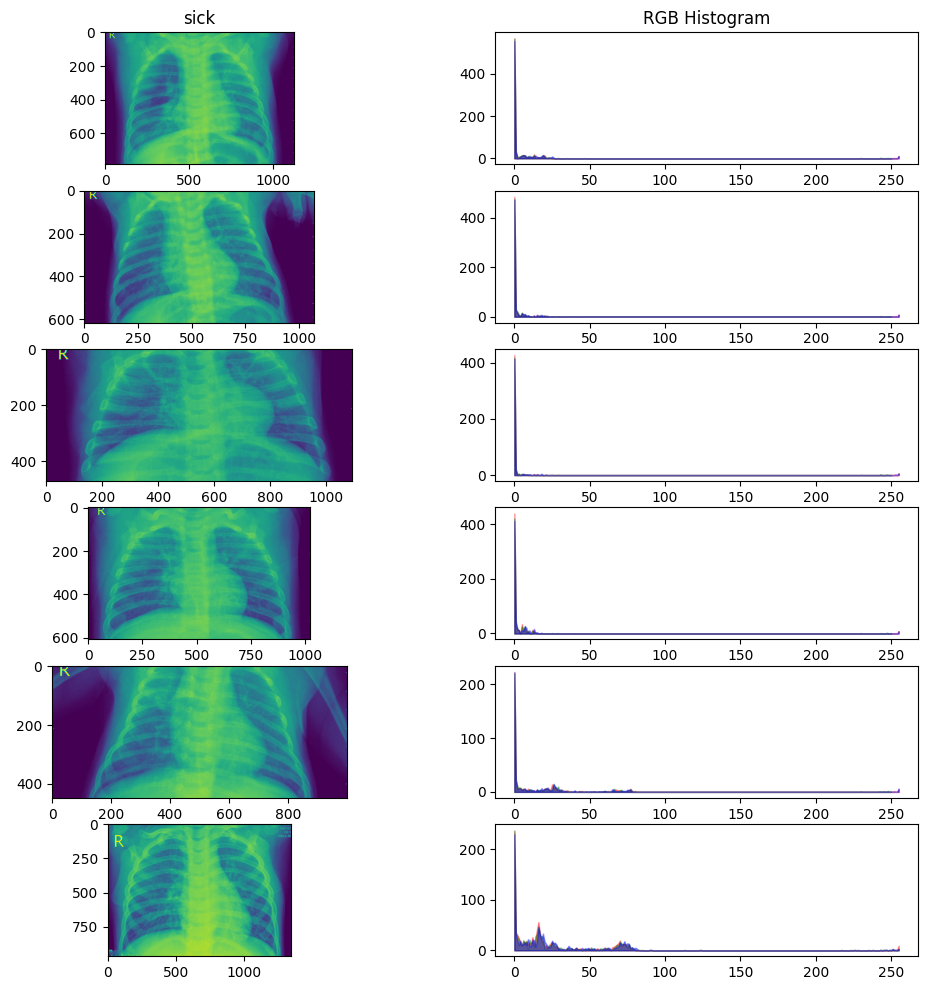

In [10]:
for paths, label in [(train_images_normal[:6],"normal"), (test_images_sick[:6], "sick")]:
    plot_graph_hist(paths, title_left = label, title_right = 'RGB Histogram', mode = 'RGB')

Things we can do after fixing the sizes of the image: generate average diagrams from sick and normal (should get better outcome)

In [36]:
from tensorflow.keras.preprocessing import image

# making n X m matrix
def img2np(list_of_filename, size = (64, 64)):
    # iterating through each file
    for i,fn in enumerate(list_of_filename):
        current_image = image.load_img(fn, target_size = size, color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
normal_images = img2np(train_images_normal[:10])
sick_images = img2np(train_images_sick[:10])

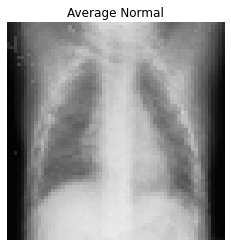

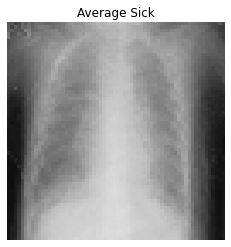

In [37]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_images, 'Normal')
sick_mean = find_mean_img(sick_images, 'Sick')

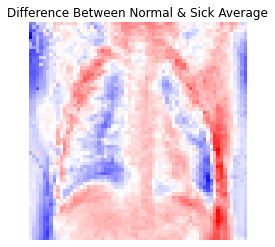

In [39]:
contrast_mean = norm_mean - sick_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Normal & Sick Average')
plt.axis('off')
plt.show()

### Image Deminsion Analysis

In [34]:
train_images = os.listdir(os.path.join(image_address, 'train'))
test_images = os.listdir(os.path.join(image_address, 'test'))
train_images_df = pd.DataFrame(train_images, columns=["filename"])
test_images_df = pd.DataFrame(test_images, columns=["filename"])

In [38]:
train_address = os.path.join(image_address, 'train')
test_address = os.path.join(image_address, 'test')

In [43]:
import cv2
# Add columns for image size, image aspect ratio, and image dimensions
train_images_df["image_size"] = train_images_df["filename"].apply(lambda x: os.path.getsize(os.path.join(train_address, x)))
train_images_df["image"] = train_images_df["filename"].apply(lambda x: cv2.imread(os.path.join(train_address, x), cv2.IMREAD_GRAYSCALE))
train_images_df["height"] = train_images_df["image"].apply(lambda x: x.shape[0])
train_images_df["width"] = train_images_df["image"].apply(lambda x: x.shape[1])
train_images_df["aspect_ratio"] = train_images_df["width"] / train_images_df["height"]


In [46]:
train_images_df.head()

,filename,image_size,image,height,width,aspect_ratio
0,person63_bacteria_306.jpeg,57793,"[[210, 208, 206, 206, 207, 207, 207, 206, 209,...",736,1048,1.423913
1,person1438_bacteria_3721.jpeg,60298,"[[0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 13, 14, 15, 16...",672,984,1.464286
2,person755_bacteria_2659.jpeg,52750,"[[45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, ...",712,992,1.393258
3,person478_virus_975.jpeg,95265,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",888,1224,1.378378
4,NORMAL2-IM-0927-0001.jpeg,2080997,"[[0, 23, 24, 26, 26, 27, 29, 27, 28, 25, 29, 2...",2234,2359,1.055953


In [48]:
# Display summary statistics for image size, aspect ratio, and dimensions
train_images_df.describe()

,image_size,height,width,aspect_ratio
count,5.309000e+03,5309.000000,5309.000000,5309.000000
mean,2.273710e+05,970.834432,1319.997551,1.435133
std,3.307003e+05,386.497723,368.514388,0.259149
min,5.441000e+03,127.000000,255.000000,0.835391
25%,5.639200e+04,688.000000,1056.000000,1.252768
50%,9.751400e+04,888.000000,1284.000000,1.407526
75%,3.011940e+05,1195.000000,1554.000000,1.580247
max,8.503175e+06,3480.000000,4248.000000,3.378788


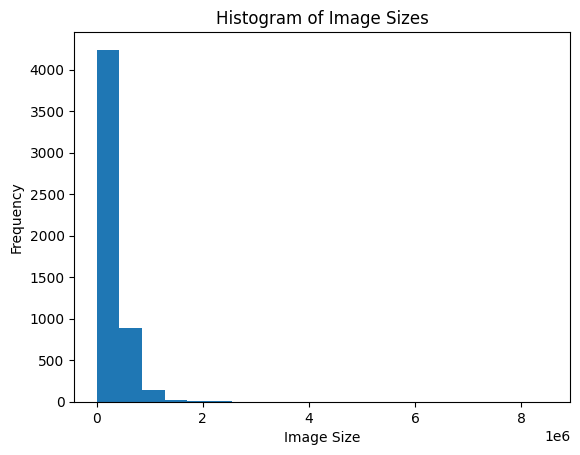

In [49]:
# Display a histogram of image sizes
plt.hist(train_images_df["image_size"], bins=20)
plt.title("Histogram of Image Sizes")
plt.xlabel("Image Size")
plt.ylabel("Frequency")
plt.show()

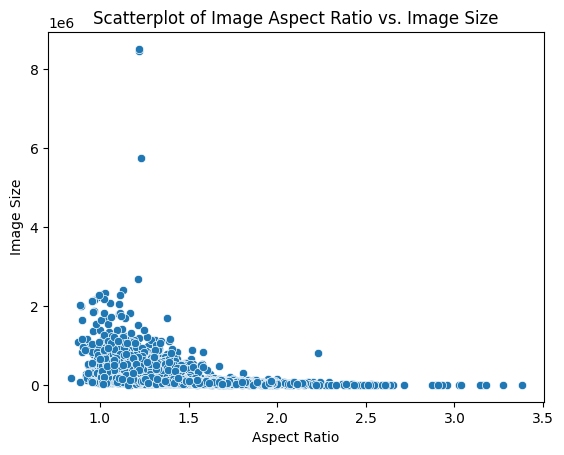

In [51]:
# Display a scatterplot of image aspect ratio vs. image size
sns.scatterplot(x=train_images_df["aspect_ratio"], y=train_images_df["image_size"])
plt.title("Scatterplot of Image Aspect Ratio vs. Image Size")
plt.xlabel("Aspect Ratio")
plt.ylabel("Image Size")
plt.show()

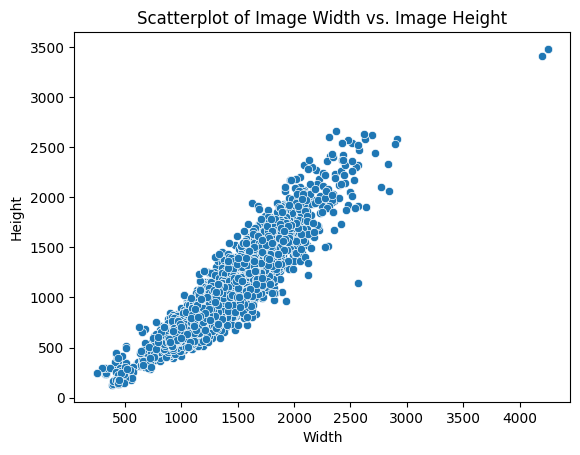

In [52]:
# Display a scatterplot of image height vs. image width
sns.scatterplot(x=train_images_df["width"], y=train_images_df["height"])
plt.title("Scatterplot of Image Width vs. Image Height")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()